In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE, SMOTENC 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Labels.xlsx") #Training Data already pre-scaled to the IBIS Data set
data = Training_Data.parse(Training_Data.sheet_names[3])
label_data = Training_Data.parse(Training_Data.sheet_names[2])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['Case','Visit','MATCH','INDEX','ASD+','ASD-','Gender'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['Final Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['CASE','MATCH','INDEX','ASD+','ASD-'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

print(data_features)

(285, 300)
(285, 1)
        ROI01     ROI02     ROI03     ROI04     ROI05     ROI06     ROI07  \
0    5.029876  3.726654  3.427438  3.981583  5.349900  4.482533  4.188761   
1    4.558297  3.523212  3.050419  3.728841  4.582860  4.732882  4.154219   
2    4.862393  3.573448  3.548558  4.120730  5.016851  4.666914  4.357041   
3    4.976339  3.560973  3.425916  4.031993  4.867496  4.528555  3.880940   
4    4.393498  3.644686  3.305453  3.924469  4.743097  4.493087  4.547651   
..        ...       ...       ...       ...       ...       ...       ...   
280  5.162674  3.802889  3.475207  4.326397  5.137480  4.480127  3.911898   
281  4.627709  3.558513  3.536533  3.896477  4.688239  4.365193  3.939188   
282  4.449460  3.756849  3.369820  3.854403  4.927545  4.515043  4.523340   
283  5.353643  3.786087  3.441294  3.878084  5.432423  4.511390  4.263558   
284  4.826855  3.932250  3.572424  4.401231  4.633188  4.511347  4.048214   

        ROI08     ROI09     ROI10  ...    ROI145.1    R

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_features)

scaled_data.shape
labels.shape

X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, labels, test_size=0.10, random_state=seed_value)
sm = SMOTENC([297],sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2)
tl = TomekLinks(sampling_strategy = 'majority')


resample = SMOTETomek(smote=sm,tomek=tl,random_state=seed_value)
#Version below works the exact same apparently. Will just pass the old smote object.
#resample = SMOTETomek(smote=SMOTENC([297],sampling_strategy='minority'),tomek=TomekLinks(sampling_strategy='majority'),random_state=seed_value)



#Imblearn has other SMOTE variants to look into.
#ADASYN - creates synthetic data according to the data density. 
#The synthetic data generation would inversely proportional to the density of the minority class. It means more synthetic data are created in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.
#In simpler terms, in an area where the minority class is less dense, the synthetic data are created more. Otherwise, the synthetic data is not made so much.

#SMOTENC - Denote which features are categorical, and SMOTE would resample the categorical data instead of creating synthetic data.

#Borderline SMOTE
#K SMOTE

#Should increase testing size. Play with testing/training split.
#X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
#X_undersampled, Y_undersampled = tl.fit_resample(X_train, Y_train)
X_resampled, Y_resampled = resample.fit_sample(X_train,Y_train)

#print(X_train_smoted.shape)
#print(Y_train_smoted.shape)
#print(X_undersampled.shape)
#print(Y_undersampled.shape)
print(X_resampled.shape)
print(Y_resampled.shape)
print(X_test.shape)

(400, 300)
(400, 1)
(29, 300)


In [4]:
#Y_train_smoted

In [5]:
#Y_undersampled

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(X_train_smoted)

In [7]:
X_resampled.shape

(400, 300)

In [8]:
#print(X_undersampled)

In [9]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 
#Need to figure out how to get dropout
#Best: 0.610920 using {'batch_size': 30, 'dropout': 0.2, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 25}
D_in, H1, H2, D_out = 300, 130, 30, 1
EPOCHS = 66
BATCH_SIZE = 20
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(X_resampled), 
                       torch.FloatTensor(Y_resampled.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(X_test))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=33) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [10]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [11]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=130, bias=True)
  (layer_2): Linear(in_features=130, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [12]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [13]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=33)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(Y_test.values))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(Y_test.values), y_pred_list)
    ppv = precision_score(Y_test, y_pred_list, average=None)
    recall = recall_score(Y_test, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.58972 | Acc: 48.750
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 002: | Loss: 1.35916 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.34550 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.34483 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.33336 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.31697 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.31586 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30151 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 009: | Loss: 1.26549 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.30064 | Acc: 50.250
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 011: | Loss: 1.22361 | Acc: 50.000
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.21011 | Acc: 50.250
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 013: | Loss: 1.17297 | Acc: 50.250
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.12493 | Acc: 51.000
Validation Accuracy |  17.24137931034483  PPV |  [1.         0.11111111]  Recall |  [0.07692308 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 015: | Loss: 1.14814 | Acc: 54.750
Validation Accuracy |  20.689655172413794  PPV |  [1.         0.11538462]  Recall |  [0.11538462 1.        ]
Training Epoch 016: | Loss: 1.15908 | Acc: 54.500
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 017: | Loss: 1.07563 | Acc: 54.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.04973 | Acc: 52.750
Validation Accuracy |  20.689655172413794  PPV |  [1.         0.11538462]  Recall |  [0.11538462 1.        ]
Training Epoch 019: | Loss: 0.97217 | Acc: 57.750
Validation Accuracy |  37.93103448275862  PPV |  [0.9        0.10526316]  Recall |  [0.34615385 0.66666667]
Training Epoch 020: | Loss: 0.98067 | Acc: 65.750
Validation Accuracy |  24.137931034482758  PPV |  [0.83333333 0.08695652]  Recall |  [0.19230769 0.66666667]
Training Epoch 021: | Loss: 0.87338 | Acc: 65.500
Validation Accuracy |  24.137931034482758  PPV |  [0.83333333 0.08695652]  Recall |  [0.19230769 0.66666667]
Training Epoch 022: | Loss: 0.84071 | Acc: 69.250
Validation Accuracy |  20.689655172413794  PPV |  [0.8        0.08333333]  Recall |  [0.15384615 0.66666667]
Training Epoch 023: | Loss: 0.78107 | Acc: 71.000
Validation Accuracy |  51.724137931034484  PPV |  [0.92857143 0

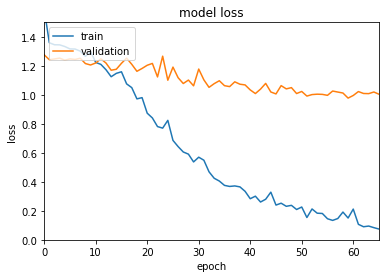

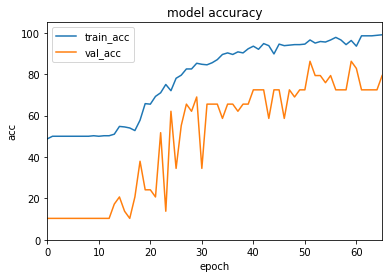

In [14]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  79.3103448275862  PPV |  [0.91666667 0.2       ]  Recall |  [0.84615385 0.33333333]


<AxesSubplot:>

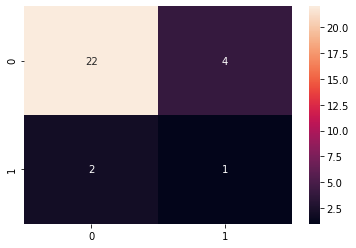

In [15]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(Y_test, y_pred_list)
ppv = precision_score(Y_test, y_pred_list, average=None)
recall = recall_score(Y_test, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(Y_test, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

In [16]:
print(classification_report(Y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        26
         1.0       0.20      0.33      0.25         3

    accuracy                           0.79        29
   macro avg       0.56      0.59      0.56        29
weighted avg       0.84      0.79      0.81        29



In [17]:
#Save model once everything is all figured out
#Models below were initially trained at 150 epochs. Re-trained for optimizing ppv, recall, and acc, without overtraining.
'''
SMOTETomek Results

10% Test - 22 08 ppv - 0.20 recall - 0.666 
            1  2 
EPOCHS = 150
BATCH_SIZE = 20
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

10% Test - 27 03 ppv - 0.40 recall - 0.666 Best
            1  2 
EPOCHS = 138
BATCH_SIZE = 20
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

10% Test - 26 04 ppv - 0.2 recall - 0.333
            2  1 
EPOCHS = 150
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.15

10% Test - 24 06 ppv - 0.25 recall - 0.666
            1  2 
EPOCHS = 150
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.15
'''

'\nSMOTETomek Results\n\n10% Test - 22 08 ppv - 0.20 recall - 0.666 \n            1  2 \nEPOCHS = 150\nBATCH_SIZE = 20\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.20\n\n10% Test - 27 03 ppv - 0.40 recall - 0.666 Best\n            1  2 \nEPOCHS = 138\nBATCH_SIZE = 20\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.20\n\n10% Test - 26 04 ppv - 0.2 recall - 0.333\n            2  1 \nEPOCHS = 150\nBATCH_SIZE = 30\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.15\n\n10% Test - 24 06 ppv - 0.25 recall - 0.666\n            1  2 \nEPOCHS = 150\nBATCH_SIZE = 30\nLEARNING_RATE = 0.001\nDROPOUT_RATE = 0.15\n'

In [18]:
torch.save(model.state_dict(), "./model_dict_hyp_2yr.pth")

In [19]:
#Use ROC curves for stability to select between hyperparameters for the pre-training
#SMOTETomek for Final model prediction